In [2]:
import math
import numpy as np

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Integration

We'll do some integrals of the form
   $$I = \int_a^b f(x) dx$$

In [3]:
from scipy import integrate
integrate?

quad is the basic integrator for a general (not sampled) function.  It uses a general-interface from the Fortran package QUADPACK (QAGS or QAGI).  It will return the integral in an interval and an estimate of the error in the approximation

In [4]:
def f(x):
    return x/sqrt(x**4 + 10*x**2 - 96*x - 71)

In [5]:
I, err = integrate.quad(f, -2, -1, epsabs=1.e-14)
print(I)
print(err)

-0.15198691759900226
1.0458679567595421e-12


In [6]:
integrate.quad?

Sometimes our integrand function takes optional arguments.

In [7]:
def g(x, A, sigma):
    return A*math.exp(-x**2/sigma**2)

In [8]:
I, err = integrate.quad(g, -1.0, 1.0, args=(1.0, 2.0))
print(I, err)

1.8451240256511698 2.0484991765669867e-14


`numpy` defines the inf quantity which can be used in the integration limits.  We can integrate a Gaussian (we know the answer is `sqrt(pi)`.

Note: behind the scenes, what the integration function does is do a variable transform like: $t = 1/x$.  This works when one limit is $\infty$, giving

$$\int_a^b f(x) dx = \int_{1/b}^{1/a} \frac{1}{t^2} f\left (\frac{1}{t}\right) dt$$

In [9]:
I, err = integrate.quad(g, -np.inf, np.inf, args=(1.0, 1.0))
print(I, err)

1.7724538509055159 1.4202636780944923e-08


### Multidimensional Integrals

Multidimensional integration can be done with successive calls to quad(), but there are wrappers that help.

Let's compute 

$$I = \int_{y=0}^{1/2} \int_{x=0}^{1-2y} xy dxdy = \frac{1}{96}$$

(this example comes from the SciPy tutorial)

Notice that the limits of integration in x depend on y.

Note the form of the function:

```
dblquad(f, a, b, ylo, yhi)
```

where f = f(y, x) -- the y argument is first.

The integral will be from: `x = [a,b]`, and `y = [ylo(x), yhi(x)]`.

In [10]:
def integrand(x,y):
    return x*y

def x_lower_lim(y):
    return 0
    
def x_upper_lim(y):
    return 1-2*y

# we change the definitions of x and y in this call
I, err = integrate.dblquad(integrand, 0.0, 0.5, x_lower_lim, x_upper_lim)
print(I, 1.0/I)


0.010416666666666668 95.99999999999999


If you remember the python lambda functions (one expression functions), you can do this more compactly:

In [11]:
I, err = integrate.dblquad(lambda x, y: x*y, 0.0, 0.5, lambda y: 0, lambda y: 1-2*y)
print(I)

0.010416666666666668


### Integration of a Smpled Function

Here we integrate a function that is defined only at a sequece of points.  Recall that Simpson's rule will use piecewise parabola data.  Let's compute

$$I = \int_0^{2\pi} f(x_i) dx$$

with $x_i = 0, \ldots, 2\pi$ defined at $N$ points.

3.14159265359


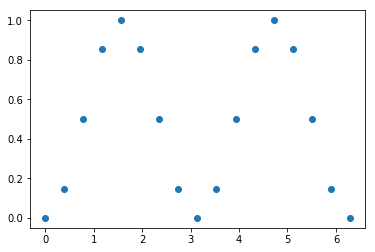

In [12]:
N = 17
x = np.linspace(0.0, 2.0*math.pi, N, endpoint=True)
y = np.sin(x)**2

plot(x, y, 'o')
integrate.simps?
I = integrate.simps(y, x)
print(I)

Romberg integration is specific to equally-spaced samples, where $N = 2^k + 1$  and can be more converge faster (it uses extrapolation of coarser integration results to achieve higher accuracy).

In [13]:
N = 17
x = np.linspace(0.0, 2.0*math.pi, N, endpoint=True)
y = np.sin(x)**2

I = integrate.romb(y, dx=x[1]-x[0])
print(I)

3.14306583533


# Interpolation

The interp1d function allows for a variety of 1-d interpolation methods.  It returns an object that acts as a function, which can be evaluated at any point.

In [14]:
import scipy.interpolate as interpolate

In [15]:
interpolate.interp1d?

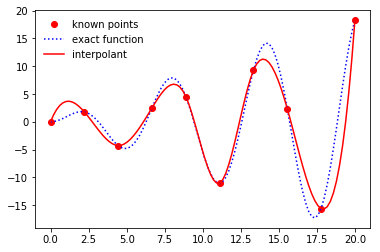

In [16]:
def fExact(x):
    return sin(x)*x

N = 10
x = np.linspace(0, 20, N)

y = fExact(x)

fInterp = interpolate.interp1d(x, y, kind=3)

# use finer points when we plot
xplot = np.linspace(0, 20, 10*N)

pylab.plot(x, y, "ro", label="known points")
pylab.plot(xplot, fExact(xplot), "b:", label="exact function")
pylab.plot(xplot, fInterp(xplot), "r-", label="interpolant")

pylab.legend(frameon=False, loc="best")

### Multi-d Interpolation

Here's an example of mult-d interpolation from the official tutorial.

First we define the "answer" -- this is the true function that we will sample at a number of points and then try to use interpolation to recover.

In [17]:
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

Here we will use mgrid to create the grid of (x,y) where we know func exactly -- this will be for plotting.  Note the fun trick here, this is not really a function, but rather something that can magically look like an array, and we index it with the `start:stop:stride`.  If we set stride to an imaginary number, then it is interpreted as the number of points to put between the start and stop.

In [18]:
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

In [19]:
print(grid_x.shape)
print(grid_y.shape)

(100, 200)
(100, 200)


Here is what the exact function looks like -- note that our function is defined in x,y, but imshow is meant for plotting an array, so the first index is the row.  We take the transpose when plotting.

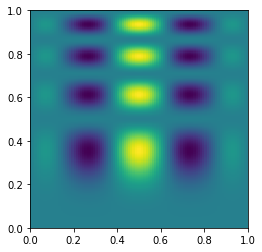

In [20]:
pylab.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin="lower")

Now we'll define 1000 random points where we'll sample the function.

In [21]:
points = np.random.rand(1000, 2)
values = func(points[:,0], points[:,1])

Here's what those points look like:

(0, 1)

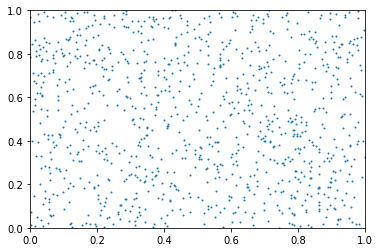

In [22]:
pylab.scatter(points[:,0], points[:,1], s=1)
pylab.xlim(0,1)
pylab.ylim(0,1)

The interpolate.griddata() function provides many ways to interpolate a collection of points into a uniform grid.  There are many different interpolation methods within this function

In [23]:
interpolate.griddata?

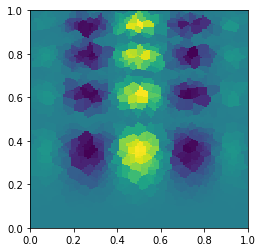

In [24]:
grid_z0 = interpolate.griddata(points, values, (grid_x, grid_y), method='nearest')
pylab.imshow(grid_z0.T, extent=(0,1,0,1), origin="lower")

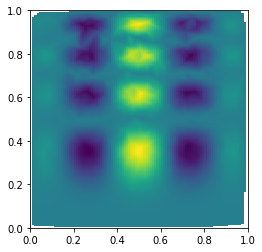

In [25]:
grid_z0 = interpolate.griddata(points, values, (grid_x, grid_y), method='linear')
pylab.imshow(grid_z0.T, extent=(0,1,0,1), origin="lower")

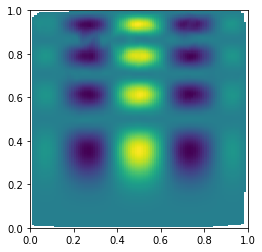

In [26]:
grid_z0 = interpolate.griddata(points, values, (grid_x, grid_y), method='cubic')
pylab.imshow(grid_z0.T, extent=(0,1,0,1), origin="lower")

# Root Finding

The `brentq()` routine offers a very robust method for find roots from a scalar function.  You do need to provide an interval that bounds the root.

$f(x) = \frac{x e^x}{e^x - 1} - 5$

In [27]:
import scipy.optimize as optimize

def f(x):
    # this is the non-linear equation that comes up in deriving Wien's law for radiation
    return (x*np.exp(x)/(np.exp(x) - 1.0) - 5.0)

root, r = optimize.brentq(f, 0.1, 10.0, full_output=True)

print(root)
print(r.converged)

4.965114231744287
True


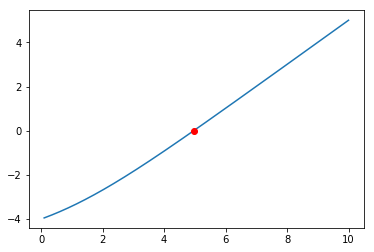

In [28]:
x = np.linspace(0.1, 10.0, 1000)
pylab.plot(x, f(x))
pylab.plot(np.array([root]), np.array([f(root)]), 'ro')

# Fitting

### General Linear Least Squares

First we'll make some experimental data (a quadratic with random fashion).  We use the randn() function to provide Gaussian normalized errors.

<Container object of 3 artists>

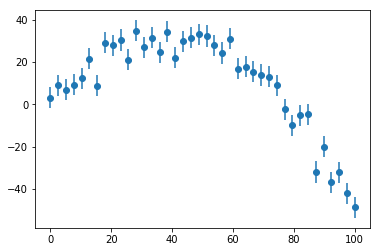

In [29]:
def y_experiment2(a1, a2, a3, sigma, x):
    """ return the experimental data in a quadratic + random fashion,                              
        with a1, a2, a3 the coefficients of the quadratic and sigma is                             
        the error.  This will be poorly matched to a linear fit for                                
        a3 != 0 """

    N = len(x)

    # randn gives samples from the "standard normal" distribution                                  
    r = numpy.random.randn(N)

    y = a1 + a2*x + a3*x*x + sigma*r

    return y

N = 40
sigma = 5.0*np.ones(N)

x = numpy.linspace(0, 100.0, N)
y = y_experiment2(2.0, 1.50, -0.02, sigma, x)

pylab.scatter(x,y)
pylab.errorbar(x, y, yerr=sigma, fmt='none')

[ 0.19454055  1.64074188 -0.02128946]


<Container object of 3 artists>

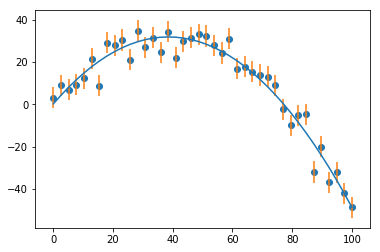

In [30]:
import scipy.optimize as optimize

def resid(avec, x, y, sigma):
    """ the residual function -- this is what will be minimized by the
        scipy.optimize.leastsq() routine.  avec is the parameters we
        are optimizing -- they are packed in here, so we unpack to
        begin.  (x, y) are the data points 

        scipy.optimize.leastsq() minimizes:

           x = arg min(sum(func(y)**2,axis=0))
                    y

        so this should just be the distance from a point to the curve,
        and it will square it and sum over the points
        """

    a0, a1, a2 = avec
    
    return (y - (a0 + a1*x + a2*x**2))/sigma


# initial guesses
a0, a1, a2 = 1, 1, 1

afit, flag = optimize.leastsq(resid, [a0, a1, a2], args=(x, y, sigma))

print(afit)

pylab.plot(x, afit[0] + afit[1]*x + afit[2]*x*x )
pylab.scatter(x,y)
pylab.errorbar(x, y, yerr=sigma, fmt='none')

$\chi^2$

In [31]:
chisq = sum(power(resid(afit, x, y, sigma),2))
normalization = len(x)-len(afit)
print(chisq/normalization)

1.12102738752


# Linear Algebra

### General Manipulations of Matrices

You can use regular NumPy arrays or you can use a special matrix class that offers some short cuts.

In [32]:
a = np.array([[1.0, 2.0], [3.0, 4.0]])

In [33]:
print(a)
print(a.transpose())
print(a.T)

[[ 1.  2.]
 [ 3.  4.]]
[[ 1.  3.]
 [ 2.  4.]]
[[ 1.  3.]
 [ 2.  4.]]


In [34]:
ainv = np.linalg.inv(a)
print(ainv)

[[-2.   1. ]
 [ 1.5 -0.5]]


In [35]:
print(numpy.dot(a, ainv))

[[  1.00000000e+00   0.00000000e+00]
 [  8.88178420e-16   1.00000000e+00]]


The eye() function will generate an identity matrix (as will the identity()).

In [36]:
print(np.eye(2))
print(np.identity(2))

[[ 1.  0.]
 [ 0.  1.]]
[[ 1.  0.]
 [ 0.  1.]]


We can solve Ax = b.

In [37]:
b = np.array([5, 7])
x = numpy.linalg.solve(a, b)
print(x)

[-3.  4.]


### The `matrix` Class

In [38]:
A = np.matrix('1.0 2.0; 3.0 4.0')
print(A)
print(A.T)

[[ 1.  2.]
 [ 3.  4.]]
[[ 1.  3.]
 [ 2.  4.]]


In [39]:
X = np.matrix('5.0 7.0')
Y = X.T

print(A*Y)

[[ 19.]
 [ 43.]]


In [40]:
print(A.I*Y)

[[-3.]
 [ 4.]]


### Tridiagonal Matrix Solve

Here we'll solve the equation:

$$f^{\prime\prime} = g(x)$$

with $g(x) = sin(x)$, and the domain $x \in [0, 2\pi]$, with boundary conditions $f(0) = f(2\pi) = 0$.  The solution is simply $f(x) = -sin(x)$.

We'll use a grid of $N$ points with $x_0$ on the left boundary and $x_{N-1}$ on the right boundary.

We difference our equation as:

$$f_{i+1} - 2 f_i + f_{i-1} = \Delta x^2 g_i$$

We keep the boundary points fixed, so we only need to solve for the $N-2$ interior points.  Near the boundaries, our difference is:
$$f_2 - 2 f_1 = \Delta x^2 g_1$$

and

$$-2f_{N-1} + f_{N-2} = \Delta x^2 g_{N-1}$$.

We can write the system of equations for solving for the $N-2$ interior points as:

\begin{equation}
A = \left (
\begin{array}{ccccccc}
-2 &  1 &    &        &         &           &          \newline
1  & -2 &  1 &        &         &           &          \newline
   &  1 & -2 & 1      &         &           &          \newline
   &         & \ddots & \ddots & \ddots  &           &          \newline
   &         &        & \ddots & \ddots  & \ddots  &          \newline
   &         &        &        & 1       & -2 & 1  \newline
   &         &        &        &         & 1  & -2 \newline
\end{array}
\right )
\end{equation}

\begin{equation}
x = \left (
\begin{array}{c}
f_\mathrm{1} \\\
f_\mathrm{2} \\\
f_\mathrm{3} \\\
\vdots \\\
\vdots \\\
f_\mathrm{N-2} \\\
f_\mathrm{N-1} \\\
\end{array}
\right )
\end{equation}

\begin{equation}
b = \Delta x^2 \left (
\begin{array}{c}
g_\mathrm{1} \\\
g_\mathrm{2} \\\
g_\mathrm{3} \\\
\vdots \\\
\vdots \\\
g_\mathrm{N-2} \\\
g_\mathrm{N-1}\\\
\end{array}
\right )
\end{equation}

Then we just solve $A x = b$

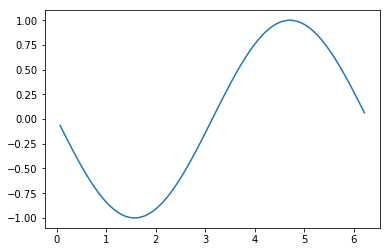

In [41]:
import scipy.linalg as linalg

# our grid -- including endpoints
N = 100
x = np.linspace(0.0, 2.0*np.pi, N, endpoint=True)
dx = x[1]-x[0]

# our source
g = np.sin(x)

# our matrix will be tridiagonal, with [1, -2, 1] on the diagonals
# we only solve for the N-2 interior points

# diagonal
d = -2*np.ones(N-2)

# upper -- note that the upper diagonal has 1 less element than the
# main diagonal.  The SciPy banded solver wants the matrix in the 
# form:
#
# *    a01  a12  a23  a34  a45    <- upper diagonal
# a00  a11  a22  a33  a44  a55    <- diagonal
# a10  a21  a32  a43  a54   *     <- lower diagonal
#

u = np.ones(N-2)
u[0] = 0.0

# lower
l = np.ones(N-2)
l[N-3] = 0.0

# put the upper, diagonal, and lower parts together as a banded matrix
A = np.matrix([u,d,l])

# solve A sol = dx**2 g for the inner N-2 points
sol = linalg.solve_banded((1,1), A, dx**2*g[1:N-1])

pylab.plot(x[1:N-1], sol)